# AD base example


In [5]:
import os, glob, json, pickle
import pandas as pd
import numpy as np

#torch related
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

# import custom class for time series dataset
from TimeDataSet import TimeseriesAnomalyDataset

# others
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


### Define litening model
__init__, forward, training_step, validation_step, test_step,configure_optimizers, etc

In [6]:
# Autoencoder and LSTM autoencoder example with pytorch lightning

class LitAutoEncoder(pl.LightningModule):
    """
    Autoencoder :
        Z = f(X)   
        X_hat = g(Z)

    LSTM Autoencoder :
        z_t = f(x_t, h_t-1)
        x_hat_t = g(z_t,h'_t-1)
    
    """

    def __init__(self, window, dim, latdim):
        super().__init__()
        # initialize network structure
        self.window = window
        self.dim = dim
        self.latdim=latdim
        # autoencoder example
        self.encoder = nn.Sequential(
            nn.Linear(self.window*self.dim,512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.latdim),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latdim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 512),
            nn.LeakyReLU(),
            nn.Linear(512, self.window*self.dim),
        )
        # LSTM autoencoder example
        self.en_LSTM = nn.LSTM(input_size = self.dim, hidden_size = 64, num_layers = 2, batch_first = True, bidirectional=True)
        self.en_lin = nn.Sequential(
            nn.Linear(64*2,self.latdim),
            nn.LeakyReLU()
        )
        self.de_LSTM = nn.LSTM(input_size = self.latdim, hidden_size = 64, num_layers = 2, batch_first = True, bidirectional=True)
        self.de_lin = nn.Sequential(
            nn.Linear(64*2,self.dim),
        )

    def anomaly_score(self, x_hat, x):
        # Define anomaly score metric
        # as MSE between raw vs predicted.
        # or you can define own anomaly score inside forward step. e.g., rapp.
        score = F.mse_loss(x_hat,x,reduction='none')
        if len(x.shape)==3:
            return score.mean(axis=(1,2)).detach().numpy()
        elif len(x.shape)==2:
            return score.mean(axis=(1)).detach().numpy()
        return score

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        # forward step for calculating anomaly score

        # Autoencoder
        # x = x.view(x.size(0), -1)
        # embedding = self.encoder(x)
        # x_hat = self.decoder(embedding)

        # LSTM Autoencoder
        z1,_ = self.en_LSTM(x)
        embedding = self.en_lin(z1)
        x_hat1,_ = self.de_LSTM(embedding)
        x_hat = self.de_lin(x_hat1)

        # define anomaly score as mse between raw vs predicted.
        AnomalyScore = self.anomaly_score(x_hat, x)
        return x_hat.detach(), AnomalyScore

    def training_step(self, batch, batch_idx):
        x, y = batch
        # Autoencoder
        # x = x.view(x.size(0), -1)
        # embedding = self.encoder(x)
        # x_hat = self.decoder(embedding)

        # LSTM Autoencoder
        z1,_ = self.en_LSTM(x)
        embedding = self.en_lin(z1)
        x_hat1,_ = self.de_LSTM(embedding)
        x_hat = self.de_lin(x_hat1)

        loss = F.mse_loss(x_hat, x)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # Autoencoder
        # x = x.view(x.size(0), -1)
        # embedding = self.encoder(x)
        # x_hat = self.decoder(embedding)

        # LSTM Autoencoder
        z1,_ = self.en_LSTM(x)
        embedding = self.en_lin(z1)
        x_hat1,_ = self.de_LSTM(embedding)
        x_hat = self.de_lin(x_hat1)
        loss = F.mse_loss(x_hat, x)
        self.log('valid_loss', loss, on_step=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        # Autoencoder
        # x = x.view(x.size(0), -1)
        # embedding = self.encoder(x)
        # x_hat = self.decoder(embedding)

        # LSTM Autoencoder
        z1,_ = self.en_LSTM(x)
        embedding = self.en_lin(z1)
        x_hat1,_ = self.de_LSTM(embedding)
        x_hat = self.de_lin(x_hat1)

        loss = F.mse_loss(x_hat, x)
        self.log('test_loss', loss, on_step=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, "monitor":"valid_loss"}
        #without lr scheduler           
        # return optimizer

Leave one-out Anomaly Detection 
    0 NO_LABEL
    1 WALKING           
    2 WALKING_UPSTAIRS  
    3 WALKING_DOWNSTAIRS
    4 SITTING           
    5 STANDING          
    6 LAYING            
    7 STAND_TO_SIT      
    8 SIT_TO_STAND      
    9 SIT_TO_LIE        
    10 LIE_TO_SIT        
    11 STAND_TO_LIE      
    12 LIE_TO_STAND      

In [7]:
# Random Settings
pl.seed_everything(1234)

# AD Settings : 
TARGET = 'HAR'
AB_CLASS = [1,2,3]
WINDOW = 128
SAMPRATE = 2
STRIDE = 62
SCALE = 'STSC' # 'STSC' : Standard scaler, 'MMSC' : Min-max scaller, None : No normalizing 
Z_DIM = 2

with open('./DataInfo.JSON','rb') as f:
    DataInfo=json.load(f)
STEP_CLASS = DataInfo[TARGET]['STEP_CLASS']
NORM_CLASS = [x for x in STEP_CLASS if x not in AB_CLASS ]
DIM = DataInfo[TARGET]['DIM']

Global seed set to 1234


In [8]:

# Create custom dataset class from pre-processed data
dataset = TimeseriesAnomalyDataset('HAR',samprate=SAMPRATE, window=WINDOW, stride = STRIDE, scaler=SCALE,  
            json_root = './DataInfo.JSON', ABNORM_STEP_CLASS=AB_CLASS)
dataset_ab = TimeseriesAnomalyDataset('HAR',samprate=SAMPRATE, window=WINDOW, stride = STRIDE, scaler=SCALE,
            json_root = './DataInfo.JSON', ABNORM_STEP_CLASS=NORM_CLASS)

# Split data into train, val, test_in (normal samples), test_out (abnormal samples)
# n_test_in == n_test_out, n_train = 80%, n_val = 20%
n_normal = len(dataset)
n_ab = len(dataset_ab)
n_train = int(0.8*(n_normal-n_ab))
n_val = n_normal-n_ab-n_train
train_, test = random_split(dataset, [n_normal-n_ab, n_ab])
train, val = random_split(train_, [n_train,n_val])

# define loaders
train_loader = DataLoader(train,256,True) # with random batch
val_loader = DataLoader(val,256)
test_in_loader = DataLoader(test,256)
test_out_loader = DataLoader(dataset_ab,256)


In [9]:
# create model
autoencoder = LitAutoEncoder(window=WINDOW, dim=DIM, latdim=Z_DIM)

# Define Callbacks e.g., early stopping
# early_stopping = EarlyStopping('valid_loss')

# train model
# trainer = pl.Trainer(gpus=[2], max_epochs=100,callbacks=[early_stopping])
trainer = pl.Trainer(gpus=[2], max_epochs=10)
trainer.fit(autoencoder, train_loader, val_dataloaders = val_loader)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 459 K 
1 | decoder | Sequential | 460 K 
2 | en_LSTM | LSTM       | 136 K 
3 | en_lin  | Sequential | 258   
4 | de_LSTM | LSTM       | 134 K 
5 | de_lin  | Sequential | 774   
---------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.766     Total estimated model params size (MB)
/home/ashryu/anaconda3/envs/AD/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/ashryu/anaconda3/envs/AD/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

## Analysis

0 tensor(4800.0693) tensor(900.)
1 tensor(9469.3867) tensor(889.)
2 tensor(7842.4761) tensor(825.)
3 tensor(9654.7744) tensor(900.)
4 tensor(5278.2930) tensor(851.)
5 tensor(8975.4551) tensor(887.)
6 tensor(9419.7246) tensor(861.)
7 tensor(5849.7646) tensor(914.)
8 tensor(5302.8447) tensor(912.)
9 tensor(14521.6855) tensor(982.)
10 tensor(5544.8706) tensor(922.)
11 tensor(485.1406) tensor(27.)
0 tensor(-27808.3145) tensor(478.)
1 tensor(-5140.4937) tensor(484.)
2 tensor(-24606.8906) tensor(509.)
3 tensor(746.9489) tensor(494.)
4 tensor(-28903.8770) tensor(497.)
5 tensor(-25816.6719) tensor(506.)
6 tensor(-27799.5664) tensor(495.)
7 tensor(-36733.6172) tensor(500.)
8 tensor(-12966.0801) tensor(498.)
9 tensor(-13303.0664) tensor(513.)
10 tensor(-9362.2754) tensor(512.)
11 tensor(99.4033) tensor(16.)


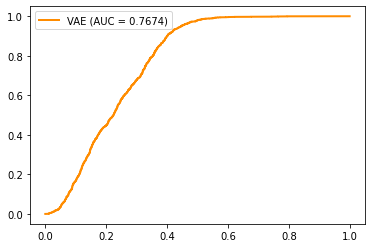

In [10]:
# Analysis
scores = []
label = []
for loader in [test_in_loader, test_out_loader]:
    for step, (x,y) in enumerate(loader):
        print(step, x.sum(), y.sum())
        x_hat,temp_score = autoencoder(x)
        scores.append(temp_score)
        y=y.numpy().reshape(-1)
        temp_label = np.array([1 if x in AB_CLASS else 0 for x in y])
        label.append(temp_label)
scores = np.concatenate(scores)
label = np.concatenate(label)

# calculate ROC
fpr, tpr, thresholds = roc_curve(label, scores, pos_label=1)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='VAE (AUC = %0.4f)' % roc_auc)
plt.legend()

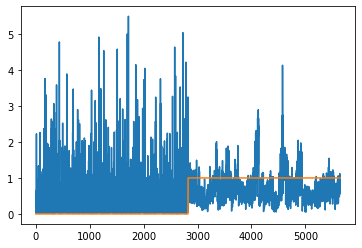

In [11]:
plt.plot(scores)
plt.plot(label)
